# RAMI solver application tutorial

This tutorial gives a practical overview of the RAMI solver application class [RamiSolverApp](../../../rst/api_reference/generated/eradiate.solvers.rami.app.RamiSolverApp.rst). This application simulates radiative transfer on scenes typically used in the RAMI benchmarking exercise.

<div class="alert alert-info">

This tutorial is available as a Jupyter notebook in the Eradiate codebase 
[`$ERADIATE_DIR/resources/data/notebooks/tutorials/rami_solver_app/rami_solver_app.ipynb`].

</div>

<div class="alert alert-info">

This notebook demonstrates features under development.

</div>

## Instantiation and configuration

We will use the Python API. We start by selecting an operational mode. We select the single-precision monochromatic mode and set the wavelength to 550 nm:

In [1]:
import eradiate
eradiate.set_mode("mono", wavelength=550.)

We then import the `RamiSolverApp` class:

In [2]:
from eradiate.solvers.rami.app import RamiSolverApp

Now, we can define our scene. For this example, we will use the [RAMI 3 homogeneous discrete canopy scene](https://rami-benchmark.jrc.ec.europa.eu/_www/phase/phase_exp.php?strTag=level3&strNext=meas&strPhase=RAMI3&strTagValue=HOM_SOL_DIS), which can be created using the [HomogeneousDiscreteCanopy](../../../rst/api_reference/generated/eradiate.scenes.biosphere.HomogeneousDiscreteCanopy.rst) class. We will use default parameters to create it quickly:

In [3]:
from eradiate.scenes.biosphere import HomogeneousDiscreteCanopy
canopy = HomogeneousDiscreteCanopy.from_parameters()
canopy

HomogeneousDiscreteCanopy(id='homogeneous_discrete_canopy', leaf_positions=<Quantity([[-2.48933986e+00  6.60973480e+00  3.43124452e-04]
 [-5.93002282e+00 -1.05973233e+01  2.77015784e-01]
 [-9.41219366e+00 -4.63317819e+00  1.19030242e+00]
 ...
 [-1.29665936e+01 -3.91847381e+00  2.88391419e+00]
 [-1.47135971e+01  1.43942399e+01  2.50906206e+00]
 [-8.77992610e+00 -1.17030281e+00  1.96632181e+00]], 'meter')>, leaf_orientations=array([[ 0.92651003, -0.37537835, -0.02588924],
       [-0.21254426,  0.39373753,  0.89431297],
       [-0.5766673 , -0.77091939, -0.27044061],
       ...,
       [-0.17160224, -0.78011441, -0.6016429 ],
       [ 0.53844264,  0.67665191,  0.5022168 ],
       [-0.3506874 , -0.32290366, -0.87906289]]), leaf_reflectance=UniformSpectrum(id=None, quantity=<PhysicalQuantity.REFLECTANCE: 9>, value=<Quantity(0.5, 'dimensionless')>), leaf_transmittance=UniformSpectrum(id=None, quantity=<PhysicalQuantity.TRANSMITTANCE: 12>, value=<Quantity(0.5, 'dimensionless')>), leaf_radius=

We will then create a Lambertian surface with reflectance 0.15. We do not care about the size of this surface: the solver will automatically match it with the size of the canopy.

In [4]:
from eradiate.scenes.surface import LambertianSurface
surface = LambertianSurface(reflectance=0.15)
surface

LambertianSurface(id='surface', width=<Quantity(100.0, 'kilometer')>, reflectance=UniformSpectrum(id=None, quantity=<PhysicalQuantity.REFLECTANCE: 9>, value=<Quantity(0.15, 'dimensionless')>))

Next up is the illumination. We use the directional illumination with the default solar irradiance spectrum and select arbitrary illumination angles:

In [5]:
from eradiate.scenes.illumination import DirectionalIllumination

illumination = DirectionalIllumination(zenith=30., azimuth=45.)
illumination

DirectionalIllumination(id='illumination', zenith=<Quantity(30.0, 'degree')>, azimuth=<Quantity(45.0, 'degree')>, irradiance=SolarIrradianceSpectrum(id=None, dataset='thuillier_2003', scale=1.0))

The last part we need to add to our scene is a measure. This solver currently supports only a distant measure, which records the radiance leaving the scene over the entire hemisphere or in a plane (we will see below how to control this behavior). 

All measures in Eradiate use an underlying kernel component called *sensor*. All sensors record their results to a *film*, which consists of a set of pixels arranged on a Cartesian grid, and the `DistantMeasure` features a `film_resolution` parameter which controls the number of pixels on the film. It should be a 2-element sequence of numbers, the first one being the width of the film, and the second being the height. We will configure our measure to produce a global view of the scene's bidirectional reflectance factor over the whole hemisphere and will set the film to a coarse resolution of 32 × 32.

When the simulation starts, the Monte Carlo algorithms traces a number rays per film pixel controlled by the `spp` (for *samples per pixel*) parameter. The higher the number of SPP, the lower the variance in results, and the higher the computational time. We will set `spp` to a rather low value of 1000 to quickly get a global view of our BRF.

One last important thing to know about measures is that they must have a unique identifier: it will be used to reference the results. We will assign the identifier `toa_brf` to our measure.

The `DistantMeasure` class has other parameters, but we do not need to modify them for now.

In [6]:
from eradiate.scenes.measure import DistantMeasure
measure = DistantMeasure(
    id="toa_brf",
    film_resolution=(32, 32),
    spp=1000,
)
measure

DistantMeasure(id='toa_brf', direction=array([0, 0, 1]), flip_directions=None, target=None, orientation=<Quantity(0.0, 'degree')>, spp=1000, film_resolution=(32, 32))

We are now ready to instantiate our scene. We just have to assemble the elements we have created so far:

In [7]:
from eradiate.solvers.rami.app import RamiScene
scene = RamiScene(
    canopy=canopy,
    surface=surface,
    illumination=illumination,
    measures=measure,
)

We can now create a solver application object with our scene:

In [8]:
from eradiate.solvers.rami.app import RamiSolverApp
app = RamiSolverApp(scene)

## Running the simulation

Once our application object is initialised, we can start the simulation by calling the [RamiSolverApp.run()](../../../rst/api_reference/generated/eradiate.solvers.rami.app.RamiSolverApp.rst#eradiate.solvers.rami.app.RamiSolverApp.run) method. Progress is displayed during computation.

In [9]:
app.run()

This method call also includes result post-processing. In addition to computing the radiance leaving the scene, the solver computes derived quantities such among which the scene's BRF. Results are stored in the `app.results` dictionary, whose keys are measure identifiers. Each item is a xarray `Dataset`, which holds one data variable per computed quantity:

In [10]:
app.results["toa_brf"]

<xarray.Dataset>
Dimensions:     (saa: 1, sza: 1, wavelength: 1, x: 32, y: 32)
Coordinates:
  * sza         (sza) float64 30.0
  * saa         (saa) float64 45.0
  * y           (y) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * x           (x) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * wavelength  (wavelength) float64 550.0
    vza         (y, x) float64 86.47 86.47 86.47 86.47 ... 86.47 86.47 86.47
    vaa         (y, x) float64 -135.0 -132.1 -129.2 -126.3 ... 50.81 47.9 45.0
Data variables:
    lo          (sza, saa, y, x, wavelength) float64 0.03119 0.04207 ... 0.06296
    irradiance  (sza, saa, wavelength) float64 1.628
    brdf        (sza, saa, y, x, wavelength) float64 0.01916 0.02585 ... 0.03868
    brf         (sza, saa, y, x, wavelength) float64 0.06021 0.08121 ... 0.1215
Attributes:
    convention:  CF-1.8
    title:       Top-of-atmosphere simulation results
    history:     2021-01-22 18:06:45 - data creation - eradiate.solvers.rami....
    source:      eradiate, version 0.0.1
    references:

This `Dataset` has 5 dimension coordinates:

- `sza`, `saa`: Sun angles, which characterize the illumination;
- `x`, `y`: film pixel coordinates, which can be mapped to the viewing angles;
- `wavelength`: the wavelength at which we just ran the simulation.

In addition, a pair of non-dimension coordinates (`vza`, `vaa`) is defined: they map pixel coordinates to the corresponding viewing angles.

Data variables are all associated to the 5 dimension coordinates, except for the irradiance, which is a property of the scene and is not a function of the viewing configuration.

## Plotting results

We can now view our results. Since we have here a xarray `Dataset`, we can use xarray's built-in visualisation capabilities:

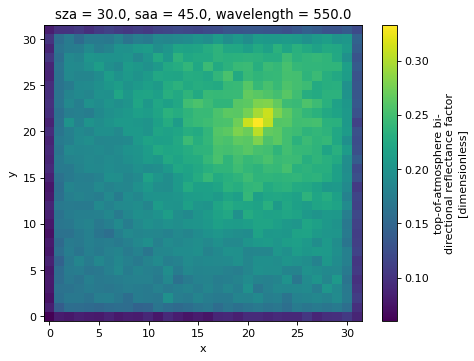

In [11]:
ds = app.results["toa_brf"]
ds.brf.squeeze().plot.imshow()

Note that we used the `squeeze()` method to drop all scalar dimensions: the `plot.imshow()` method is indeed meant to be used on 2D data arrays. On this image, we can see that we indeed have a hotspot in the direction of the illumination, as we would expect. This is good news! However, the results are quite noisy.

## More samples in the principal plane

We are now going to run a new simulation with a different measure configuration. We will still use the `DistantMeasure` element, but we will set its film height to 1 pixel. This will trigger a special behaviour where the underlying kernel sensor will sample directions only on a plane defined by the measure's `orientation` parameter. We will set `orientation` to the same value as the Sun azimuth angle: this will make our sensor record radiance in the principal plane.

Since we will be taking samples for much fewer pixels, we can increase the SPP at a reasonable computational cost. Let's increase it up to 100000 to reduce that noise.

In [12]:
measure = DistantMeasure(
    id="toa_brf",
    film_resolution=(32, 1),
    spp=100000,
    orientation=45.
)

We can now redefine a scene and run our computation:

In [13]:
scene = RamiScene(
    canopy=canopy,
    surface=surface,
    illumination=illumination,
    measures=measure,
)
app = RamiSolverApp(scene)
app.run()

Let's inspect our results:

In [14]:
ds = app.results["toa_brf"]
ds

<xarray.Dataset>
Dimensions:     (saa: 1, sza: 1, wavelength: 1, x: 32, y: 1)
Coordinates:
  * sza         (sza) float64 30.0
  * saa         (saa) float64 45.0
  * y           (y) int64 0
  * x           (x) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * wavelength  (wavelength) float64 550.0
    vza         (y, x) float64 87.19 81.56 75.94 70.31 ... -75.94 -81.56 -87.19
    vaa         (y, x) float64 45.0 45.0 45.0 45.0 45.0 ... 45.0 45.0 45.0 45.0
Data variables:
    lo          (sza, saa, y, x, wavelength) float64 0.06574 0.09879 ... 0.03694
    irradiance  (sza, saa, wavelength) float64 1.628
    brdf        (sza, saa, y, x, wavelength) float64 0.04039 0.0607 ... 0.02269
    brf         (sza, saa, y, x, wavelength) float64 0.1269 0.1907 ... 0.07129
Attributes:
    convention:  CF-1.8
    title:       Top-of-atmosphere simulation results
    history:     2021-01-22 18:06:58 - data creation - eradiate.solvers.rami....
    source:      eradiate, version 0.0.1
    references:

We still have the same data variables and coordinates; however, if we take a look at coordinate values, we can see that the only dimension coordinate with non-unit length is `x`: our data is one-dimensional, which is what we expect from a computation in the principal plane!

In [15]:
da = ds.brf.squeeze()
da

<xarray.DataArray 'brf' (x: 32)>
array([0.12689867, 0.19068814, 0.22252104, 0.2337008 , 0.23881474,
       0.24417922, 0.248764  , 0.25727039, 0.26432275, 0.2877227 ,
       0.35426408, 0.30119163, 0.26448152, 0.24905465, 0.23788991,
       0.23007769, 0.22207012, 0.21467294, 0.20749729, 0.20000099,
       0.19428015, 0.18945702, 0.1843943 , 0.18047791, 0.17728217,
       0.17495115, 0.17244586, 0.17174301, 0.17041719, 0.16522537,
       0.14089651, 0.07129426])
Coordinates:
    sza         float64 30.0
    saa         float64 45.0
    y           int64 0
  * x           (x) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
    wavelength  float64 550.0
    vza         (x) float64 87.19 81.56 75.94 70.31 ... -75.94 -81.56 -87.19
    vaa         (x) float64 45.0 45.0 45.0 45.0 45.0 ... 45.0 45.0 45.0 45.0
Attributes:
    standard_name:  toa_brf
    long_name:      top-of-atmosphere bi-directional reflectance factor
    units:          dimensionless

We can now plot our data, again using xarray's plotting facilities. The mapping of the viewing zenith angle is such that the direction pointed at by the measure's `orientation` parameter, which we set to be the backscattering orientation, is located to the right of the plot, where the VZA takes positive values.

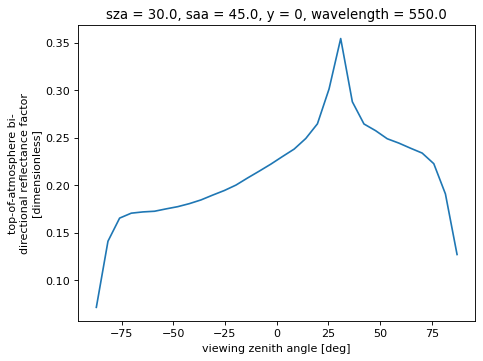

In [16]:
da.plot(x="vza")